In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df['is_attack'] = df['attack'].apply(lambda x: 0 if x=='normal' else 1)
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag,is_attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [4]:
scan = set(['ipsweep', 'portsweep', 'nmap', 'satan'])
dos = set(['neptune', 'smurf', 'pod', 'teardrop', 'land'])
access = set(['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezclient', 'warezmaster'])
exploit = set(['buffer_overflow', 'loadmodule', 'rootkit', 'perl'])
backdoor = set(['back','spy'])

df['attack_category'] = None

for i in range(len(df)):
  attk = df.loc[i,'attack']
  if attk in scan:
    df.loc[i,'attack_category'] = 'scan'
  elif attk in dos:
    df.loc[i,'attack_category'] = 'dos'
  elif attk in access:
    df.loc[i,'attack_category'] = 'access'
  elif attk in exploit:
    df.loc[i,'attack_category'] = 'exploit'
  elif attk in backdoor:
    df.loc[i,'attack_category'] = 'backdoor'
  else:
    df.loc[i,'attack_category'] = 'normal'

In [5]:
# land, wrongfragment,urgent,loggedin,rootshell,suattempted,numshells,ishostlogin,isguestlogin
df['land'] = df['land'].astype('category')
df['wrongfragment'] = df['wrongfragment'].astype('category')
df['urgent'] = df['urgent'].astype('category')
df['loggedin'] = df['loggedin'].astype('category')
df['rootshell'] = df['rootshell'].astype('category')
df['suattempted'] = df['suattempted'].astype('category')
df['numshells'] = df['numshells'].astype('category')
df['ishostlogin'] = df['ishostlogin'].astype('category')
df['isguestlogin'] = df['isguestlogin'].astype('category')

In [6]:
# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

In [7]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
all_attacks = df['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks:
    category_data = df[df['attack'] == category]

    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)

    elif len(category_data) == 1:
        train_data = pd.concat([train_data,category_data])
        continue

    elif len(category_data) > 1 and len(category_data) <= 5:
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue

    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue


    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    train_data = pd.concat([train_data,category_train])
    test_data = pd.concat([test_data,category_test])

In [8]:
X_train = train_data.drop(['attack','is_attack','attack_category'],axis=1)
y_train = train_data['is_attack']
X_test = test_data.drop(['attack','is_attack','attack_category'],axis=1)
y_test = test_data['is_attack']

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [10]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [11]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,class_weight='balanced',n_estimators=100,
                            min_samples_split= 7,
                            max_features= 'sqrt',
                            max_depth= 30)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

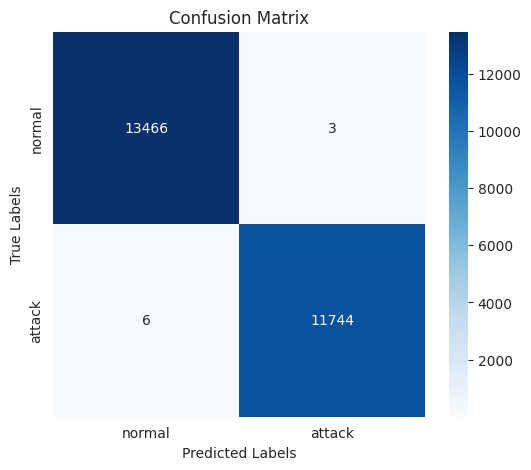

In [12]:
from sklearn.metrics import confusion_matrix


cmrf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'attack'], yticklabels=['normal', 'attack'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=['normal','attack']))

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     13469
      attack       1.00      1.00      1.00     11750

    accuracy                           1.00     25219
   macro avg       1.00      1.00      1.00     25219
weighted avg       1.00      1.00      1.00     25219



In [14]:
y_pred_df = pd.DataFrame(y_pred,index=y_test.index)
y_pred_df.isna().sum()

,0
0,0


In [15]:
combined_pred = pd.concat([y_test,y_pred_df],axis=1)
combined_pred.columns = ['is_attack','is_attack_pred']
predicted_probabilities = rf.predict_proba(X_test)
combined_pred['predict_prob'] = predicted_probabilities[:, 1]
combined_pred.head()

,is_attack,is_attack_pred,predict_prob
18091,0,0,0.0
29741,0,0,0.0
76709,0,0,0.0
91928,0,0,0.0
39962,0,0,0.0


In [16]:
fimp = rf.feature_importances_

# Create a DataFrame for easy display
imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': fimp
})
imp = imp.sort_values(by='Importance', ascending=False)
imp.head(10)

,Feature,Importance
5,dstbytes,0.126188
4,srcbytes,0.124635
47,diffsrv,0.064994
41,lastflag,0.063783
32,dsthostsrvcount,0.057992
29,diffsrvrate,0.047145
28,samesrvrate,0.040431
33,dsthostsamesrvrate,0.038279
11,loggedin,0.036371
3,flag,0.033398


In [17]:
combined_pred_eq = combined_pred[combined_pred['is_attack'] == combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred[combined_pred['is_attack'] != combined_pred['is_attack_pred']]
combined_pred_uneq = combined_pred_uneq[combined_pred_uneq['is_attack'] == 1]
combined_pred = pd.concat([combined_pred_eq,combined_pred_uneq],axis=0)
combined_pred.shape

(25216, 3)

In [18]:
op = pd.merge(X_test,combined_pred[['is_attack','is_attack_pred']],left_index=True,right_index=True)
op = pd.merge(op,df[['attack','attack_category']],left_index=True,right_index=True)
op.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,attack,attack_category
18091,-0.109310,2.223211,-1.176110,0.751252,-0.007738,-0.005282,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.182970,2.168276,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.336057,0.736054,1.258277,1.066418,-0.438899,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-0.657260,-0.540987,-0.251742,-0.242121,-0.503694,1.161659,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,1.304684,-0.292247,0,0,normal,normal
29741,-0.109310,-0.124696,-0.442321,0.751252,-0.007699,-0.002285,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,1.233669,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.585910,-0.148039,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.374565,0.736054,1.258277,1.066418,-0.438899,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.099836,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,1.304684,-0.292247,0,0,normal,normal
76709,-0.109310,2.223211,-1.176110,0.751252,-0.007741,-0.005290,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.725707,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,0.770831,-0.349280,-0.374565,-1.378981,0.734386,1.066418,-0.438899,2.765688,-0.199837,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.329199,-0.196052,-0.625486,-0.343015,-0.173356,-0.418804,0.800655,-0.292247,0,0,normal,normal
91928,-0.109310,2.223211,1.086406,0.751252,-0.007729,-0.005277,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.673283,-0.368641,-0.637521,-0.632055,-0.374383,-0.374543,-1.185430,1.260395,-0.374565,0.736054,1.204081,1.021860,-0.385959,-0.479531,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,-0.657260,-0.540987,-0.251742,-0.242121,-0.503694,-0.329485,-0.155959,-0.625486,-0.343015,-0.173356,-0.418804,1.209266,0.212254,0,0,normal,normal
39962,-0.098889,2.223211,-1.176110,0.751252,-0.007741,-0.005303,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.810590,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.708232,-0.313490,-0.637521,-0.632055,-0.374383,-0.374543,-0.753233,3.369625,1.165770,-1.207764,-0.755994,-0.002991,-0.174195,-0.414627,-0.288575,-0.639313,-0.624805,-0.387837,-0.376431,0.654638,-0.540987,-0.251742,-0.242121,-0.503694,-0.329342,-0.156354,-0.625486,-0.343015,-0.173356,-0.418804,-0.766701,0.031930,0,0,normal,normal


In [19]:
attacks = op[np.logical_or(op['is_attack_pred'] == 1,np.logical_or(op['is_attack_pred'] == 1,op['is_attack'] == 1))].copy()
attacks.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,is_attack,is_attack_pred,attack,attack_category
25445,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.100384,-0.327278,1.601975,1.604940,-0.374383,-0.374543,-1.458396,-0.016244,-0.374565,0.736054,-1.008907,-1.116959,-0.068313,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,1.861644,-0.251742,-0.242121,0.157630,-0.283326,0.052797,1.655712,-0.343015,-0.173356,-0.020284,-0.910610,-0.235516,1,1,neptune,dos
71233,-0.10931,-0.124696,1.453300,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.275129,-0.299703,1.601975,1.604940,-0.374383,-0.374543,-1.435649,-0.016244,-0.374565,0.736054,-0.873418,-1.005562,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,2.090466,-0.251742,-0.242121,0.488292,-0.244621,0.076497,1.655712,-0.343015,-0.173356,1.474165,-0.899748,-0.061271,1,1,neptune,dos
30788,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.187757,-0.313490,-0.637521,-0.632055,2.746133,2.713628,-1.458396,0.039262,-0.374565,0.736054,-0.999874,-1.116959,-0.068313,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,3.211260,1.514881,-0.503694,-0.280459,0.108097,-0.625486,3.321361,0.002502,-0.418804,-0.910436,-0.221333,1,1,neptune,dos
30951,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.174233,-0.368641,-0.637521,-0.632055,2.746133,2.713628,-1.481144,0.150274,-0.374565,0.736054,-1.036005,-1.161518,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.385313,0.109279,-0.503694,-0.328625,-0.011192,-0.625486,3.321361,-0.138184,-0.418804,-0.911305,-0.274012,1,1,neptune,dos
111798,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.934376,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.412902,0.039262,-0.374565,0.736054,-0.981809,-1.094680,-0.015372,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,2.754773,2.217682,-0.503694,-0.234013,0.068005,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.178785,1,1,neptune,dos


In [20]:
augmented_train = X_train[X_train.index.isin(y_train[y_train==1].index)]
augmented_output = df[df.index.isin(y_train[y_train==1].index)]['attack']
augmented_attack = pd.merge(augmented_train,augmented_output,left_index=True,right_index=True)
augmented_attack.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack
76074,-0.10931,-0.124696,0.536064,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.790629,-0.175614,1.601975,1.604940,-0.374383,-0.374543,-1.390155,-0.016244,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,2.765491,-0.251742,-0.242121,1.976270,-0.136391,0.146412,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune
116621,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.252868,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.367408,0.094768,-0.374565,0.736054,-0.981809,-1.094680,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.526982,2.217682,-0.503694,-0.246341,-0.017512,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.164602,neptune
71284,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.016962,-0.368641,1.601975,1.604940,-0.374383,-0.374543,-1.481144,0.094768,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,0.442948,-0.251742,-0.242121,-0.338363,-0.331206,-0.060172,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune
74957,-0.10931,-0.124696,0.169170,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.418877,-0.230765,1.601975,1.604940,-0.374383,-0.374543,-1.321913,-0.071750,-0.374565,0.736054,-0.945679,-1.072400,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,0.969238,-0.251742,-0.242121,1.314946,-0.192155,-0.065702,1.655712,-0.343015,-0.173356,0.677125,-0.907482,-0.180811,neptune
102313,-0.10931,-0.124696,1.759045,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.620859,-0.272127,1.601975,1.604940,-0.374383,-0.374543,-0.093563,0.483310,-0.374565,0.736054,-0.503081,-0.626813,-0.333018,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,-0.657260,-0.392253,-0.251742,-0.242121,0.818954,-0.227992,-0.157539,1.655712,-0.343015,-0.173356,5.558992,-0.786167,-0.049114,neptune


In [21]:
augmented_attack = pd.merge(augmented_attack,df['attack_category'],left_index=True,right_index=True)
augmented_attack.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack,attack_category
76074,-0.10931,-0.124696,0.536064,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.790629,-0.175614,1.601975,1.604940,-0.374383,-0.374543,-1.390155,-0.016244,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,2.765491,-0.251742,-0.242121,1.976270,-0.136391,0.146412,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune,dos
116621,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.252868,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.367408,0.094768,-0.374565,0.736054,-0.981809,-1.094680,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.526982,2.217682,-0.503694,-0.246341,-0.017512,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.164602,neptune,dos
71284,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.016962,-0.368641,1.601975,1.604940,-0.374383,-0.374543,-1.481144,0.094768,-0.374565,0.736054,-0.909548,-1.027842,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,0.442948,-0.251742,-0.242121,-0.338363,-0.331206,-0.060172,1.655712,-0.343015,-0.173356,1.075645,-0.903484,-0.109897,neptune,dos
74957,-0.10931,-0.124696,0.169170,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.418877,-0.230765,1.601975,1.604940,-0.374383,-0.374543,-1.321913,-0.071750,-0.374565,0.736054,-0.945679,-1.072400,-0.174195,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,0.969238,-0.251742,-0.242121,1.314946,-0.192155,-0.065702,1.655712,-0.343015,-0.173356,0.677125,-0.907482,-0.180811,neptune,dos
102313,-0.10931,-0.124696,1.759045,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,-0.620859,-0.272127,1.601975,1.604940,-0.374383,-0.374543,-0.093563,0.483310,-0.374565,0.736054,-0.503081,-0.626813,-0.333018,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,-0.657260,-0.392253,-0.251742,-0.242121,0.818954,-0.227992,-0.157539,1.655712,-0.343015,-0.173356,5.558992,-0.786167,-0.049114,neptune,dos


In [22]:
tst = attacks.drop(['is_attack_pred','is_attack'],axis=1)
tst = pd.concat([tst,augmented_attack],axis=0)
tst.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag,serror,rerror,srvserror,srvrerror,samesrv,diffsrv,dsthostserror,dsthostrerror,dsthostsrvserror,dsthostsrvrerror,dsthostsamesrv,dsthostdiffsrv,attack,attack_category
25445,-0.10931,-0.124696,1.086406,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.100384,-0.327278,1.601975,1.604940,-0.374383,-0.374543,-1.458396,-0.016244,-0.374565,0.736054,-1.008907,-1.116959,-0.068313,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.654638,1.861644,-0.251742,-0.242121,0.157630,-0.283326,0.052797,1.655712,-0.343015,-0.173356,-0.020284,-0.910610,-0.235516,neptune,dos
71233,-0.10931,-0.124696,1.453300,-0.735719,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.275129,-0.299703,1.601975,1.604940,-0.374383,-0.374543,-1.435649,-0.016244,-0.374565,0.736054,-0.873418,-1.005562,-0.121254,-0.479531,-0.288575,1.609062,1.618961,-0.387837,-0.376431,0.217339,2.090466,-0.251742,-0.242121,0.488292,-0.244621,0.076497,1.655712,-0.343015,-0.173356,1.474165,-0.899748,-0.061271,neptune,dos
30788,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,1.187757,-0.313490,-0.637521,-0.632055,2.746133,2.713628,-1.458396,0.039262,-0.374565,0.736054,-0.999874,-1.116959,-0.068313,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,3.211260,1.514881,-0.503694,-0.280459,0.108097,-0.625486,3.321361,0.002502,-0.418804,-0.910436,-0.221333,neptune,dos
30951,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.174233,-0.368641,-0.637521,-0.632055,2.746133,2.713628,-1.481144,0.150274,-0.374565,0.736054,-1.036005,-1.161518,0.037568,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,1.385313,0.109279,-0.503694,-0.328625,-0.011192,-0.625486,3.321361,-0.138184,-0.418804,-0.911305,-0.274012,neptune,dos
111798,-0.10931,-0.124696,1.086406,-2.222691,-0.007746,-0.00531,-0.013734,-0.091208,-0.007426,-0.095649,-0.026347,-0.81059,-0.021129,-0.036493,-0.025575,-0.021312,-0.026201,-0.017925,-0.040271,0.0,-0.00315,-0.097771,0.934376,-0.285915,-0.637521,-0.632055,2.746133,2.713628,-1.412902,0.039262,-0.374565,0.736054,-0.981809,-1.094680,-0.015372,-0.479531,-0.288575,-0.639313,-0.624805,2.873477,2.754328,0.654638,-0.540987,2.754773,2.217682,-0.503694,-0.234013,0.068005,-0.625486,3.321361,0.072845,-0.418804,-0.909480,-0.178785,neptune,dos


In [23]:
all_attacks1 = tst['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train1_data = pd.DataFrame()
test1_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks1:
    # Get data for the current category
    category_data = tst[tst['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)
    elif len(category_data) == 1:
        test1_data = pd.concat([test1_data,category_data])
        noise_data = category_data.copy()
        noise_data['count'] += 0.0001
        #display(category_data)
        #display(noise_data)
        train1_data = pd.concat([train1_data,noise_data],axis=0)
        # print(train1_data[train1_data['attack'] == category].shape)
        continue
    elif len(category_data) > 1 and len(category_data) <= 5:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test1_data = pd.concat([test1_data,test_selection])
        train1_data = pd.concat([train1_data,train_selection])

        noise_data = train_selection.copy()
        noise_data['count'] += 0.0001
        train1_data = pd.concat([train1_data,noise_data],axis=0)
        continue

    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test1_data = pd.concat([test1_data,test_selection])
        train1_data = pd.concat([train1_data,train_selection])
        continue


    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    train1_data = pd.concat([train1_data,category_train])
    test1_data = pd.concat([test1_data,category_test])

In [24]:
X1_train = train1_data.drop(['attack','attack_category'],axis=1)
y1_train = train1_data['attack_category']
X1_test = test1_data.drop(['attack','attack_category'],axis=1)
y1_test = test1_data['attack_category']

In [25]:
target_encoder = LabelEncoder()
y1_train_encoded = target_encoder.fit_transform(y1_train)
y1_test_encoded = target_encoder.transform(y1_test)
target_classes = [target_encoder.classes_[i] for i in range(len(target_encoder.classes_))]

In [26]:
rf2 = RandomForestClassifier(random_state=42,class_weight='balanced',
                             n_estimators= 200,
                            min_samples_split=2,
                            max_features='log2',
                            max_depth=None)
rf2.fit(X1_train,y1_train_encoded)
y_pred1 = rf2.predict(X1_test)

In [27]:
fimp2 = rf2.feature_importances_

# Create a DataFrame for easy display
imp2 = pd.DataFrame({
    'Feature': X1_train.columns,
    'Importance': fimp2
})
imp2 = imp2.sort_values(by='Importance', ascending=False)
imp2.head(10)

,Feature,Importance
4,srcbytes,0.097402
5,dstbytes,0.076241
41,lastflag,0.060667
11,loggedin,0.055688
2,service,0.048920
32,dsthostsrvcount,0.047110
12,numcompromised,0.040516
34,dsthostdiffsrvrate,0.037128
52,dsthostsamesrv,0.034283
46,samesrv,0.033694


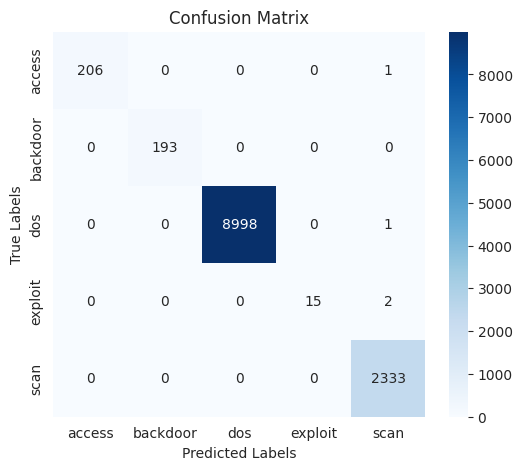

In [28]:
cm1 = confusion_matrix(y1_test_encoded, y_pred1)

plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=target_classes, yticklabels=target_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
print(classification_report(y1_test_encoded, y_pred1,target_names=target_classes))

              precision    recall  f1-score   support

      access       1.00      1.00      1.00       207
    backdoor       1.00      1.00      1.00       193
         dos       1.00      1.00      1.00      8999
     exploit       1.00      0.88      0.94        17
        scan       1.00      1.00      1.00      2333

    accuracy                           1.00     11749
   macro avg       1.00      0.98      0.99     11749
weighted avg       1.00      1.00      1.00     11749



In [30]:
y1_pred_df = pd.DataFrame(y_pred1,index=y1_test.index)
y1_pred_df.isna().sum()

,0
0,0


In [31]:
combined_pred1 = pd.concat([y1_test,y1_pred_df],axis=1)
combined_pred1.columns = ['attack_category','attack_category_pred']
predicted_probabilities1 = rf2.predict_proba(X1_test)
combined_pred1['predict_prob'] = predicted_probabilities1[:, 1]

In [32]:
ocategory = dict()
for i in range(len(target_encoder.classes_)):
    ocategory[i] = target_encoder.classes_[i]
ocategory

{0: 'access', 1: 'backdoor', 2: 'dos', 3: 'exploit', 4: 'scan'}

In [33]:
combined_pred1['attack_category_pred'] = combined_pred1['attack_category_pred'].map(ocategory)

In [34]:
op1 = pd.merge(X1_test,combined_pred1,left_index=True,right_index=True)
op1 = pd.merge(op1,df['attack'],left_index=True,right_index=True)
op1.drop(['attack_category_pred','predict_prob'],axis=1,inplace=True)

augmented_train1 = X1_train.copy()
augmented_output1 = df[df.index.isin(augmented_train1.index)][['attack_category','attack']]
augmented_attack1 = pd.merge(augmented_train1,augmented_output1,left_index=True,right_index=True)

final = pd.concat([augmented_attack1,op1],axis=0)

In [35]:
dos_data = final[final['attack_category'] == 'dos'].copy()
dos_data.drop('attack_category',axis=1,inplace=True)

scan_data = final[final['attack_category'] == 'scan'].copy()
scan_data.drop('attack_category',axis=1,inplace=True)

backdoor_data = final[final['attack_category'] == 'backdoor'].copy()
backdoor_data.drop('attack_category',axis=1,inplace=True)

access_data = final[final['attack_category'] == 'access'].copy()
access_data.drop('attack_category',axis=1,inplace=True)

exploit_data = final[final['attack_category'] == 'exploit'].copy()
exploit_data.drop('attack_category',axis=1,inplace=True)

In [36]:
dos_train = pd.DataFrame()
dos_test = pd.DataFrame()

for category in dos_data['attack'].unique():
    # Get data for the current category
    category_data = dos_data[dos_data['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) == 1:
        dos_train = pd.concat([dos_train,category_data])
        continue
    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    dos_train = pd.concat([dos_train,category_train])
    dos_test = pd.concat([dos_test,category_test])

dosxtrain = dos_train.drop(['attack'],axis=1)
dosytrain = dos_train['attack']
dosxtest = dos_test.drop(['attack'],axis=1)
dosytest = dos_test['attack']

In [37]:
scan_train = pd.DataFrame()
scan_test = pd.DataFrame()

for category in scan_data['attack'].unique():
    # Get data for the current category
    category_data = scan_data[scan_data['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) == 1:
        scan_train = pd.concat([scan_train,category_data])
        continue
    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    scan_train = pd.concat([scan_train,category_train])
    scan_test = pd.concat([scan_test,category_test])

scanxtrain = scan_train.drop(['attack'],axis=1)
scanytrain = scan_train['attack']
scanxtest = scan_test.drop(['attack'],axis=1)
scanytest = scan_test['attack']

In [38]:
access_train = pd.DataFrame()
access_test = pd.DataFrame()

for category in access_data['attack'].unique():
    # Get data for the current category
    category_data = access_data[access_data['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) == 1:
        access_train = pd.concat([access_train,category_data])
        continue
    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    access_train = pd.concat([access_train,category_train])
    access_test = pd.concat([access_test,category_test])

accessxtrain = access_train.drop(['attack'],axis=1)
accessytrain = access_train['attack']
accessxtest = access_test.drop(['attack'],axis=1)
accessytest = access_test['attack']

In [39]:
backdoor_train = pd.DataFrame()
backdoor_test = pd.DataFrame()

for category in backdoor_data['attack'].unique():
    # Get data for the current category
    category_data = backdoor_data[backdoor_data['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) == 1:
        backdoor_train = pd.concat([backdoor_train,category_data])
        continue
    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    backdoor_train = pd.concat([backdoor_train,category_train])
    backdoor_test = pd.concat([backdoor_test,category_test])

backdoorxtrain = backdoor_train.drop(['attack'],axis=1)
backdoorytrain = backdoor_train['attack']
backdoorxtest = backdoor_test.drop(['attack'],axis=1)
backdoorytest = backdoor_test['attack']

In [40]:
exploit_train = pd.DataFrame()
exploit_test = pd.DataFrame()

for category in exploit_data['attack'].unique():
    # Get data for the current category
    category_data = exploit_data[exploit_data['attack'] == category]
    #print(category)
    # Split into train and test, ensuring each category appears in test
    if len(category_data) == 1:
        exploit_train = pd.concat([exploit_train,category_data])
        continue
    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)

    # Append to the train and test sets
    exploit_train = pd.concat([exploit_train,category_train])
    exploit_test = pd.concat([exploit_test,category_test])

exploitxtrain = exploit_train.drop(['attack'],axis=1)
exploitytrain = exploit_train['attack']
exploitxtest = exploit_test.drop(['attack'],axis=1)
exploitytest = exploit_test['attack']

In [41]:
dos_encoder = LabelEncoder()
dosytrain = dos_encoder.fit_transform(dosytrain)
dosytest = dos_encoder.transform(dosytest)

scan_encoder = LabelEncoder()
scanytrain = scan_encoder.fit_transform(scanytrain)
scanytest = scan_encoder.transform(scanytest)

access_encoder = LabelEncoder()
accessytrain = access_encoder.fit_transform(accessytrain)
accessytest = access_encoder.transform(accessytest)

backdoor_encoder = LabelEncoder()
backytrain = backdoor_encoder.fit_transform(backdoorytrain)
backytest = backdoor_encoder.transform(backdoorytest)

exploit_encoder = LabelEncoder()
exploitytrain= exploit_encoder.fit_transform(exploitytrain)
exploitytest = exploit_encoder.transform(exploitytest)

In [42]:
rfdos = RandomForestClassifier(class_weight='balanced',random_state=42)
rfdos.fit(dosxtrain, dosytrain)
y_pred_dos= rfdos.predict(dosxtest)

rfscan = RandomForestClassifier(class_weight='balanced',random_state=42)
rfscan.fit(scanxtrain, scanytrain)
y_pred_scan= rfscan.predict(scanxtest)

rfback = RandomForestClassifier(class_weight='balanced',random_state=42)
rfback.fit(backdoorxtrain, backdoorytrain)
y_pred_back = rfback.predict(backdoorxtest)

rfaccess = RandomForestClassifier(class_weight='balanced',random_state=42)
rfaccess.fit(accessxtrain, accessytrain)
y_pred_access= rfaccess.predict(accessxtest)

rfexploit = RandomForestClassifier(class_weight='balanced',random_state=42)
rfexploit.fit(exploitxtrain, exploitytrain)
y_pred_exploit = rfexploit.predict(exploitxtest)

In [43]:
from sklearn.linear_model import LogisticRegression

logreg_dos = LogisticRegression(random_state=42,class_weight='balanced',
                                   multi_class='multinomial', solver='lbfgs',max_iter=100,C=0.01)
logreg_dos.fit(dosxtrain,dosytrain)
y_pred_log_reg_dos = logreg_dos.predict(dosxtest)

fimp_dos = logreg_dos.coef_
feature_importance_dos = np.abs(fimp_dos)
mean_importance = np.mean(feature_importance_dos, axis=0)

#Create a DataFrame for easy display
impdos = pd.DataFrame({
    'Feature': dosxtrain.columns,
    'Importance': mean_importance
})
impdos = impdos.sort_values(by='Importance', ascending=False)
impdos.head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Feature,Importance
7,wrongfragment,0.524181
1,protocoltype,0.435196
2,service,0.174934
41,lastflag,0.137716
46,samesrv,0.132220
23,srvcount,0.126553
31,dsthostcount,0.124639
28,samesrvrate,0.118340
3,flag,0.117655
37,dsthostserrorrate,0.109491


In [45]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros_dict_exp = dict()
smote_dict_exp = dict()
exploit_labels = [exploit_encoder.classes_[i] for i in range(len(np.unique(exploitytest)))]

for i in range(len(exploit_data['attack'].unique())):
    data_shape = exploit_data[exploit_data['attack'] == exploit_labels[i]].shape[0]
    if data_shape < 10:
        ros_dict_exp[i] = 10
    smote_dict_exp[i] = 200


ros = RandomOverSampler(sampling_strategy=ros_dict_exp,random_state=42)
exp_xtrain_resampled, exp_ytrain_resampled = ros.fit_resample(exploitxtrain, exploitytrain)

smote = SMOTE(sampling_strategy=smote_dict_exp,random_state=42)
exp_xtrain_smote, exp_ytrain_smote = smote.fit_resample(exp_xtrain_resampled, exp_ytrain_resampled)

brfexp2 = RandomForestClassifier(random_state=42)
brfexp2.fit(exp_xtrain_smote, exp_ytrain_smote)
y_pred_exp_brf2= brfexp2.predict(exploitxtest)

fimpexp = brfexp2.feature_importances_

# Create a DataFrame for easy display
impexp = pd.DataFrame({
    'Feature': exp_xtrain_smote.columns,
    'Importance': fimpexp
})
impexp = impexp.sort_values(by='Importance', ascending=False)
impexp.head(10)

,Feature,Importance
17,numshells,0.071141
31,dsthostcount,0.070421
16,numfilecreations,0.069720
1,protocoltype,0.063153
52,dsthostsamesrv,0.057181
33,dsthostsamesrvrate,0.052005
4,srcbytes,0.045393
53,dsthostdiffsrv,0.044335
29,diffsrvrate,0.044327
34,dsthostdiffsrvrate,0.041828


In [46]:
fimpscan = rfscan.feature_importances_

# Create a DataFrame for easy display
impscan = pd.DataFrame({
    'Feature': scanxtrain.columns,
    'Importance': fimpscan
})
impscan = impscan.sort_values(by='Importance', ascending=False)
impscan.head(10)

,Feature,Importance
36,dsthostsrvdiffhostrate,0.197249
31,dsthostcount,0.095350
26,rerrorrate,0.079859
22,count,0.067299
34,dsthostdiffsrvrate,0.045113
49,dsthostrerror,0.042711
29,diffsrvrate,0.040274
39,dsthostrerrorrate,0.034288
4,srcbytes,0.033836
47,diffsrv,0.030720


In [47]:
fimpback = rfback.feature_importances_

# Create a DataFrame for easy display
impback = pd.DataFrame({
    'Feature': backdoorxtrain.columns,
    'Importance': fimpback
})
impback = impback.sort_values(by='Importance', ascending=False)
impback.head(10)

,Feature,Importance
0,duration,0.104908
38,dsthostsrvserrorrate,0.104738
34,dsthostdiffsrvrate,0.104651
53,dsthostdiffsrv,0.081395
33,dsthostsamesrvrate,0.077519
2,service,0.070844
51,dsthostsrvrerror,0.059995
16,numfilecreations,0.058140
37,dsthostserrorrate,0.058140
4,srcbytes,0.046512


In [48]:
fimpaccess = rfaccess.feature_importances_

# Create a DataFrame for easy display
impaccess = pd.DataFrame({
    'Feature':accessxtrain.columns,
    'Importance': fimpaccess
})
impaccess = impaccess.sort_values(by='Importance', ascending=False)
impaccess.head(10)

,Feature,Importance
5,dstbytes,0.078656
52,dsthostsamesrv,0.077227
32,dsthostsrvcount,0.071256
31,dsthostcount,0.068780
11,loggedin,0.051479
4,srcbytes,0.044572
41,lastflag,0.042855
2,service,0.038865
0,duration,0.032000
10,numfailedlogins,0.031858


In [49]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros_dict_access = dict()
smote_dict_access = dict()
access_labels = [access_encoder.classes_[i] for i in range(len(np.unique(accessytest)))]

for i in range(len(access_data['attack'].unique())):
    data_shape = access_data[access_data['attack'] == access_labels[i]].shape[0]
    if data_shape < 10:
        ros_dict_access[i] = 10
    smote_dict_access[i] = 1000


ros_access = RandomOverSampler(sampling_strategy=ros_dict_access,random_state=42)
access_xtrain_resampled, access_ytrain_resampled = ros_access.fit_resample(accessxtrain, accessytrain)

smote_access = SMOTE(sampling_strategy=smote_dict_access,random_state=42)
access_xtrain_smote, access_ytrain_smote = smote_access.fit_resample(access_xtrain_resampled, access_ytrain_resampled)

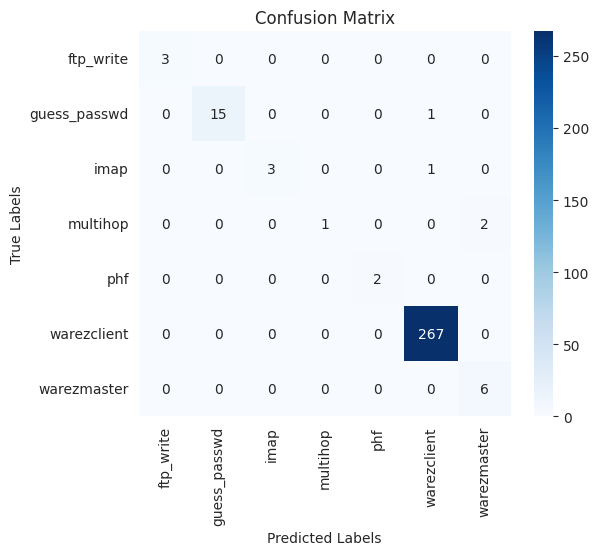

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,metric='manhattan',weights='distance')
knn.fit(access_xtrain_smote, access_ytrain_smote)
y_pred_knn = knn.predict(accessxtest)
cmknnmaccess = confusion_matrix(accessytest, y_pred_knn)

plt.figure(figsize=(6, 5))
sns.heatmap(cmknnmaccess, annot=True, fmt='d', cmap='Blues',xticklabels=access_labels,yticklabels=access_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print(classification_report(accessytest, y_pred_knn,target_names=access_labels))

              precision    recall  f1-score   support

   ftp_write       1.00      1.00      1.00         3
guess_passwd       1.00      0.94      0.97        16
        imap       1.00      0.75      0.86         4
    multihop       1.00      0.33      0.50         3
         phf       1.00      1.00      1.00         2
 warezclient       0.99      1.00      1.00       267
 warezmaster       0.75      1.00      0.86         6

    accuracy                           0.99       301
   macro avg       0.96      0.86      0.88       301
weighted avg       0.99      0.99      0.99       301



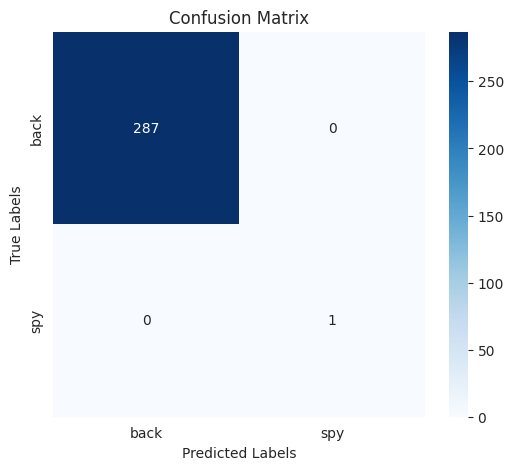

In [62]:
cmsback = confusion_matrix(backdoorytest, y_pred_back)
back_labels = [backdoor_encoder.classes_[i] for i in range(len(np.unique(backdoorytest)))]

plt.figure(figsize=(6, 5))
sns.heatmap(cmsback, annot=True, fmt='d', cmap='Blues',xticklabels=back_labels, yticklabels=back_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [63]:
print(classification_report(backdoorytest, y_pred_back,target_names=back_labels))

              precision    recall  f1-score   support

        back       1.00      1.00      1.00       287
         spy       1.00      1.00      1.00         1

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



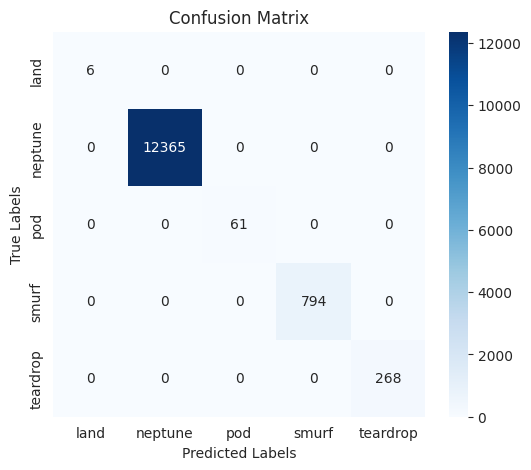

In [60]:
cmdoslog = confusion_matrix(dosytest, y_pred_log_reg_dos)
dos_labels = [dos_encoder.classes_[i] for i in range(len(np.unique(dosytest)))]
plt.figure(figsize=(6, 5))
sns.heatmap(cmdoslog, annot=True, fmt='d', cmap='Blues',xticklabels=dos_labels, yticklabels=dos_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [61]:
print(classification_report(dosytest,y_pred_log_reg_dos,target_names=dos_labels))

              precision    recall  f1-score   support

        land       1.00      1.00      1.00         6
     neptune       1.00      1.00      1.00     12365
         pod       1.00      1.00      1.00        61
       smurf       1.00      1.00      1.00       794
    teardrop       1.00      1.00      1.00       268

    accuracy                           1.00     13494
   macro avg       1.00      1.00      1.00     13494
weighted avg       1.00      1.00      1.00     13494



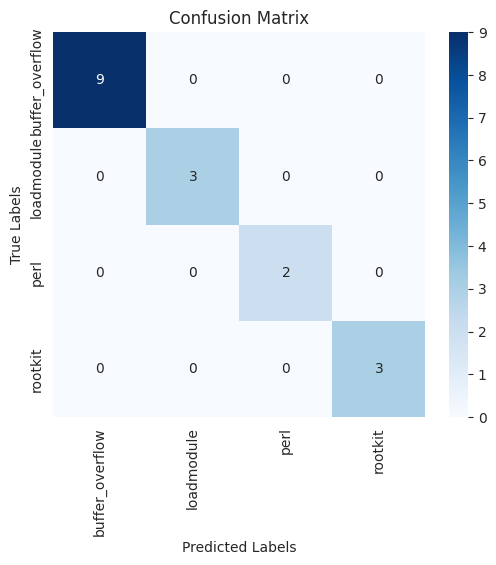

In [64]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros_dict_exp = dict()
smote_dict_exp = dict()

for i in range(len(exploit_data['attack'].unique())):
    data_shape = exploit_data[exploit_data['attack'] == exploit_labels[i]].shape[0]
    if data_shape < 10:
        ros_dict_exp[i] = 10
    smote_dict_exp[i] = 200


ros = RandomOverSampler(sampling_strategy=ros_dict_exp,random_state=42)
exp_xtrain_resampled, exp_ytrain_resampled = ros.fit_resample(exploitxtrain, exploitytrain)

smote = SMOTE(sampling_strategy=smote_dict_exp,random_state=42)
exp_xtrain_smote, exp_ytrain_smote = smote.fit_resample(exp_xtrain_resampled, exp_ytrain_resampled)

brfexp2 = RandomForestClassifier(random_state=42)
brfexp2.fit(exp_xtrain_smote, exp_ytrain_smote)
y_pred_exp_brf2= brfexp2.predict(exploitxtest)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(exploitytest,y_pred_exp_brf2), annot=True, fmt='d', cmap='Blues',xticklabels=exploit_labels,yticklabels=exploit_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [65]:
print(classification_report(exploitytest, y_pred_exp_brf2,target_names=exploit_labels))

                 precision    recall  f1-score   support

buffer_overflow       1.00      1.00      1.00         9
     loadmodule       1.00      1.00      1.00         3
           perl       1.00      1.00      1.00         2
        rootkit       1.00      1.00      1.00         3

       accuracy                           1.00        17
      macro avg       1.00      1.00      1.00        17
   weighted avg       1.00      1.00      1.00        17



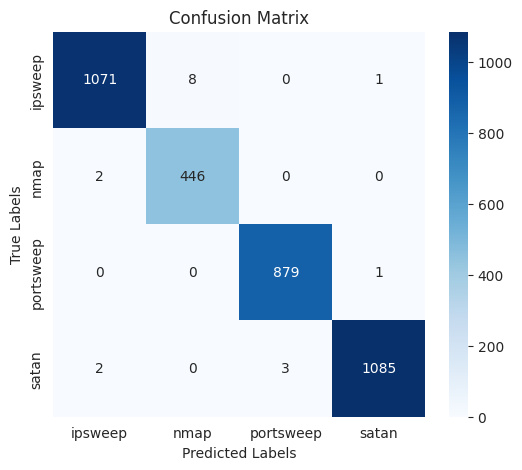

In [52]:
cmscan = confusion_matrix(scanytest, y_pred_scan)
scan_labels = [scan_encoder.classes_[i] for i in range(len(np.unique(scanytest)))]

plt.figure(figsize=(6, 5))
sns.heatmap(cmscan, annot=True, fmt='d', cmap='Blues',xticklabels=scan_labels, yticklabels=scan_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [53]:
print(classification_report(scanytest, y_pred_scan,target_names=scan_labels))

              precision    recall  f1-score   support

     ipsweep       1.00      0.99      0.99      1080
        nmap       0.98      1.00      0.99       448
   portsweep       1.00      1.00      1.00       880
       satan       1.00      1.00      1.00      1090

    accuracy                           1.00      3498
   macro avg       0.99      1.00      0.99      3498
weighted avg       1.00      1.00      1.00      3498



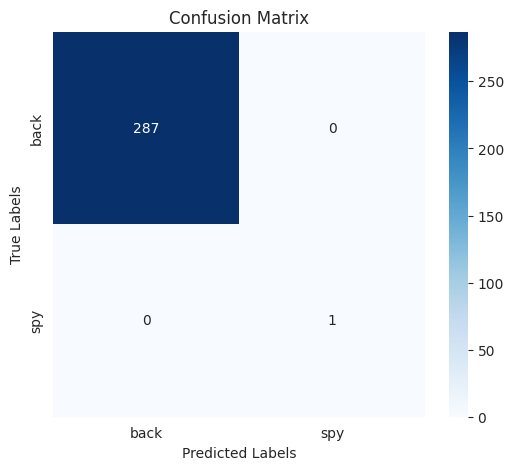

In [54]:
cmsback = confusion_matrix(backdoorytest, y_pred_back)
back_labels = [backdoor_encoder.classes_[i] for i in range(len(np.unique(backdoorytest)))]

plt.figure(figsize=(6, 5))
sns.heatmap(cmsback, annot=True, fmt='d', cmap='Blues',xticklabels=back_labels, yticklabels=back_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
print(classification_report(backdoorytest, y_pred_back,target_names=back_labels))

              precision    recall  f1-score   support

        back       1.00      1.00      1.00       287
         spy       1.00      1.00      1.00         1

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



In [56]:
imp.head()

,Feature,Importance
5,dstbytes,0.126188
4,srcbytes,0.124635
47,diffsrv,0.064994
41,lastflag,0.063783
32,dsthostsrvcount,0.057992


In [66]:
imp['m1_rank'] = imp['Importance'].rank(ascending=False, method='min')
imp2['m2_rank'] = imp2['Importance'].rank(ascending=False, method='min')
impaccess['access_rank'] = impaccess['Importance'].rank(ascending=False, method='min')
impback['back_rank'] = impback['Importance'].rank(ascending=False, method='min')
impdos['dos_rank'] = impdos['Importance'].rank(ascending=False, method='min')
impexp['exp_rank'] = impexp['Importance'].rank(ascending=False, method='min')
impscan['scan_rank'] = impscan['Importance'].rank(ascending=False, method='min')

In [67]:
imp[['Feature','m1_rank']].head()

,Feature,m1_rank
5,dstbytes,1.0
4,srcbytes,2.0
47,diffsrv,3.0
41,lastflag,4.0
32,dsthostsrvcount,5.0


In [68]:
final_imp = pd.merge(imp[['Feature','m1_rank']],imp2[['Feature','m2_rank']],on='Feature',how='inner')
final_imp = pd.merge(final_imp,impaccess[['Feature','access_rank']],on='Feature',how='inner')
final_imp = pd.merge(final_imp,impback[['Feature','back_rank']],on='Feature',how='inner')
final_imp = pd.merge(final_imp,impdos[['Feature','dos_rank']],on='Feature',how='inner')
final_imp = pd.merge(final_imp,impexp[['Feature','exp_rank']],on='Feature',how='inner')
final_imp = pd.merge(final_imp,impscan[['Feature','scan_rank']],on='Feature',how='inner')
final_imp['rank_sum'] = final_imp['m1_rank']+final_imp['m2_rank']+final_imp['access_rank']+final_imp['back_rank']+final_imp['dos_rank']+final_imp['exp_rank']+final_imp['scan_rank']

In [69]:
imps = final_imp[['Feature','rank_sum']].sort_values('rank_sum',ascending=True)
imps.set_index('Feature',inplace=True)
sdf = df.dtypes
imps = pd.concat([imps,sdf],axis=1)
imps.head()

,rank_sum,0
dsthostsamesrv,83.0,float64
lastflag,85.0,int64
srcbytes,86.0,int64
service,87.0,object
dsthostcount,93.0,int64


In [77]:
imps.drop(['attack','is_attack','attack_category'],axis=0,inplace=True)

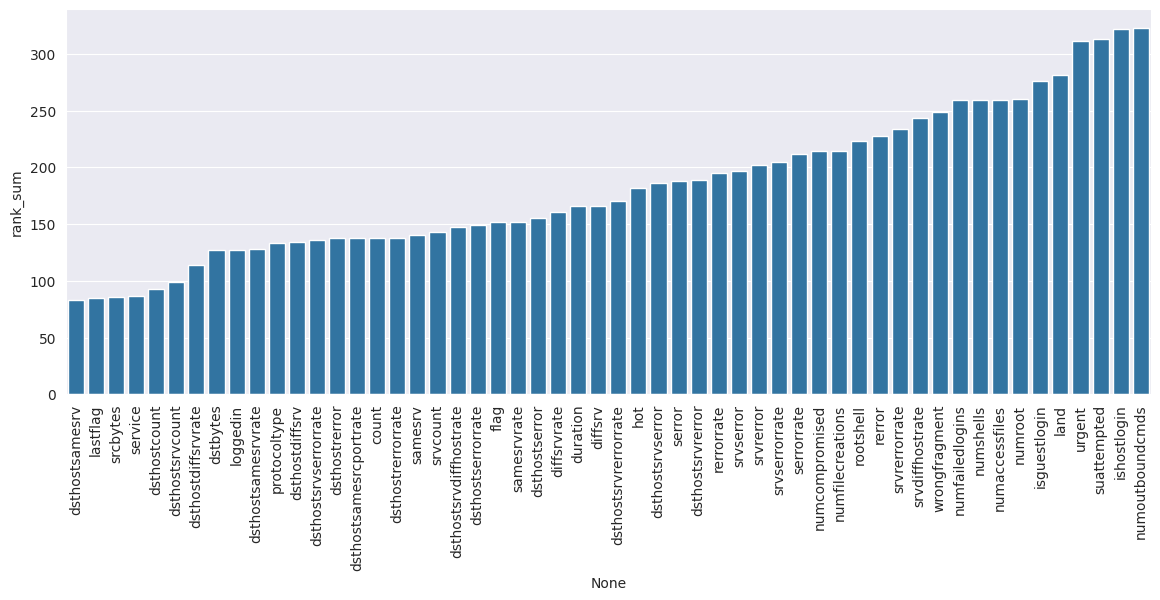

In [78]:
plt.figure(figsize=(14,5))
sns.barplot(data=imps,x=imps.index,y='rank_sum')
plt.xticks(rotation=90)
plt.show()

In [81]:
import shap
# Initialize SHAP explainer (TreeExplainer for RandomForest)
explainer_binary = shap.TreeExplainer(rf)

# Calculate SHAP values for the test set
binary_values = explainer_binary.shap_values(X_test)

shap.summary_plot(binary_values[1], X_test)

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.